In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    DATASET_NAME = "ag_news"
    NUM_LABELS = 4
    MAX_LENGTH = 128

    TRAIN_SAMPLES = 5_000
    TEST_SAMPLES = 500

    BATCH_TRAIN = 32
    BATCH_EVAL = 64
    EPOCHS = 2
    LR = 5e-5
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 100
    SEED = 42

    TOP_N_WORDS = 20

    OUTPUT_DIR = "./results"
    SAVE_DIR = "./fine-tuned-distilbert"

# =============================================================================
# INSTALL & IMPORTS
# =============================================================================
!pip install -q transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import pandas as pd
import re

In [4]:
# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def print_device_info():
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

def clean_text_for_eda(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
def run_eda(dataset):
    print("\n========== EDA: AG News Dataset ==========")

    train_df = dataset["train"].to_pandas()
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    train_df["label_name"] = train_df["label"].map(label_map)

    # ---------------------------------------------------------
    # 1. Label Distribution
    # ---------------------------------------------------------
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x="label_name", order=label_map.values())
    plt.title("Label Distribution (Train Set)")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    print("\nLabel Distribution:")
    print(train_df["label_name"].value_counts(normalize=True))

    # ---------------------------------------------------------
    # 2. Text Length Analysis
    # ---------------------------------------------------------
    train_df["char_length"] = train_df["text"].apply(len)
    train_df["word_length"] = train_df["text"].apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(train_df["word_length"], bins=50, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(train_df["char_length"], bins=50, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

    print("\nText Length Statistics:")
    print(train_df[["word_length", "char_length"]].describe())

    # ---------------------------------------------------------
    # 3. Top Words per Class
    # ---------------------------------------------------------
    print("\nTop Words per Category:")
    for label, name in label_map.items():
        texts = train_df[train_df["label"] == label]["text"]
        all_words = []

        for text in texts:
            cleaned = clean_text_for_eda(text)
            all_words.extend(cleaned.split())

        common_words = Counter(all_words).most_common(Config.TOP_N_WORDS)

        print(f"\n{name}:")
        for word, freq in common_words[:10]:
            print(f"  {word}: {freq}")

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data():
    dataset = load_dataset(Config.DATASET_NAME)

    train_data = dataset["train"].shuffle(seed=Config.SEED).select(
        range(Config.TRAIN_SAMPLES)
    )
    test_data = dataset["test"].shuffle(seed=Config.SEED).select(
        range(Config.TEST_SAMPLES)
    )

    return DatasetDict({"train": train_data, "test": test_data})


# =============================================================================
# TOKENIZATION
# =============================================================================
def tokenize_dataset(dataset, tokenizer):
    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=Config.MAX_LENGTH,
        )

    tokenized = dataset.map(tokenize_fn, batched=True)
    tokenized = tokenized.remove_columns("text")
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")

    return tokenized


# =============================================================================
# MODEL
# =============================================================================
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS,
    )
    return tokenizer, model


# =============================================================================
# METRICS
# =============================================================================
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)[
            "accuracy"
        ],
        "f1": f1.compute(
            predictions=preds, references=labels, average="weighted"
        )["f1"],
    }


# =============================================================================
# TRAINING
# =============================================================================
def train_model(model, tokenized_data):
    args = TrainingArguments(
        output_dir=Config.OUTPUT_DIR,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_TRAIN,
        per_device_eval_batch_size=Config.BATCH_EVAL,
        learning_rate=Config.LR,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        report_to="none",
        seed=Config.SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["test"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer


# =============================================================================
# EVALUATION & ANALYSIS
# =============================================================================
def evaluate_model(trainer, tokenized_data):
    predictions = trainer.predict(tokenized_data["test"])
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    labels = ["World", "Sports", "Business", "Sci/Tech"]

    print("\nClassification Report")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


# =============================================================================
# INFERENCE
# =============================================================================
def predict(text, model, tokenizer):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    label = torch.argmax(probs, dim=-1).item()

    return label, probs[0][label].item()


# =============================================================================
# MAIN PIPELINE
# =============================================================================
def main():
    set_seed(Config.SEED)
    print_device_info()

    dataset = load_data()

    run_eda(dataset)

    tokenizer, model = load_model()
    tokenized = tokenize_dataset(dataset, tokenizer)
    trainer = train_model(model, tokenized)

    evaluate_model(trainer, tokenized)

    model.save_pretrained(Config.SAVE_DIR)
    tokenizer.save_pretrained(Config.SAVE_DIR)
    print(f"\nModel saved to {Config.SAVE_DIR}")

    samples = [
        "Scientists discover a new exoplanet",
        "Stock markets hit record highs",
        "The team won the championship final",
    ]

    label_map = ["World", "Sports", "Business", "Sci/Tech"]

    for text in samples:
        label, conf = predict(text, model, tokenizer)
        print(f"\nText: {text}")
        print(f"Prediction: {label_map[label]} ({conf:.2%})")

PyTorch: 2.9.0+cu126
CUDA available: True

========== EDA: AG News Dataset ==========


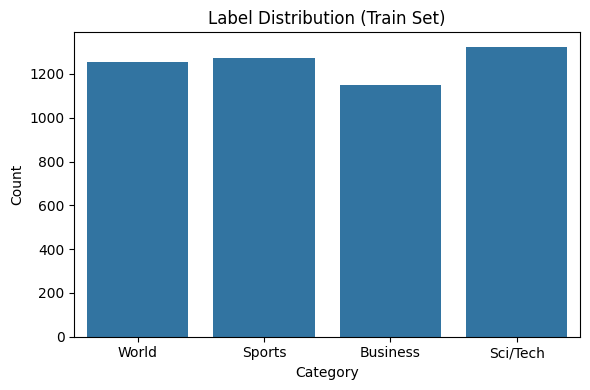


Label Distribution:
label_name
Sci/Tech    0.2648
Sports      0.2546
World       0.2506
Business    0.2300
Name: proportion, dtype: float64


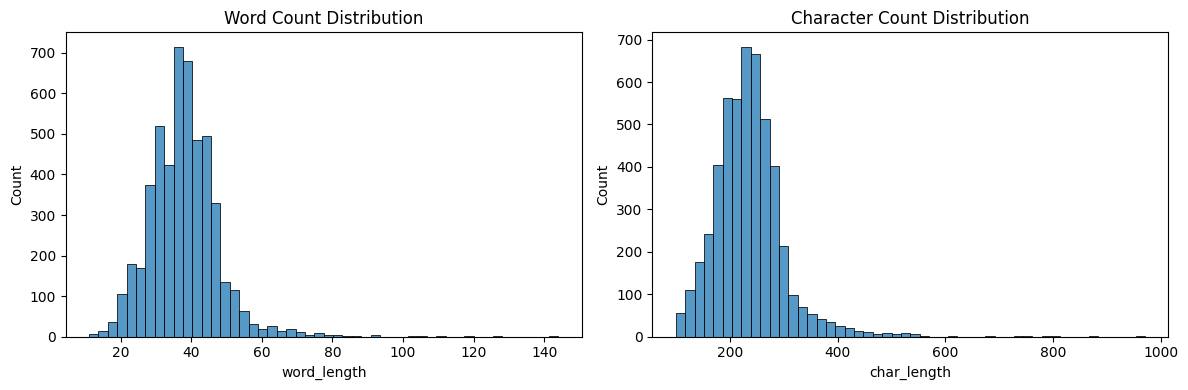


Text Length Statistics:
       word_length  char_length
count  5000.000000   5000.00000
mean     37.727600    235.56920
std       9.794375     65.01999
min      11.000000    100.00000
25%      32.000000    195.00000
50%      37.000000    232.00000
75%      43.000000    266.00000
max     144.000000    970.00000

Top Words per Category:

World:
  the: 2030
  in: 1278
  to: 1271
  a: 1252
  of: 1218
  and: 739
  on: 670
  for: 494
  said: 326
  s: 294

Sports:
  the: 2651
  to: 1175
  a: 1099
  in: 1022
  of: 844
  and: 651
  for: 586
  on: 508
  s: 379
  at: 374

Business:
  the: 1669
  to: 1149
  a: 999
  of: 881
  in: 845
  and: 628
  on: 622
  for: 464
  its: 402
  s: 357

Sci/Tech:
  the: 2071
  to: 1335
  a: 1194
  of: 1139
  and: 808
  in: 765
  for: 578
  on: 496
  that: 399
  its: 368


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374700,0.389052,0.876000,0.875971
2,0.215600,0.306253,0.890000,0.890196



Classification Report
              precision    recall  f1-score   support

       World     0.9352    0.8417    0.8860       120
      Sports     0.9756    0.9917    0.9836       121
    Business     0.8561    0.8433    0.8496       134
    Sci/Tech     0.8102    0.8880    0.8473       125

    accuracy                         0.8900       500
   macro avg     0.8943    0.8912    0.8916       500
weighted avg     0.8925    0.8900    0.8902       500



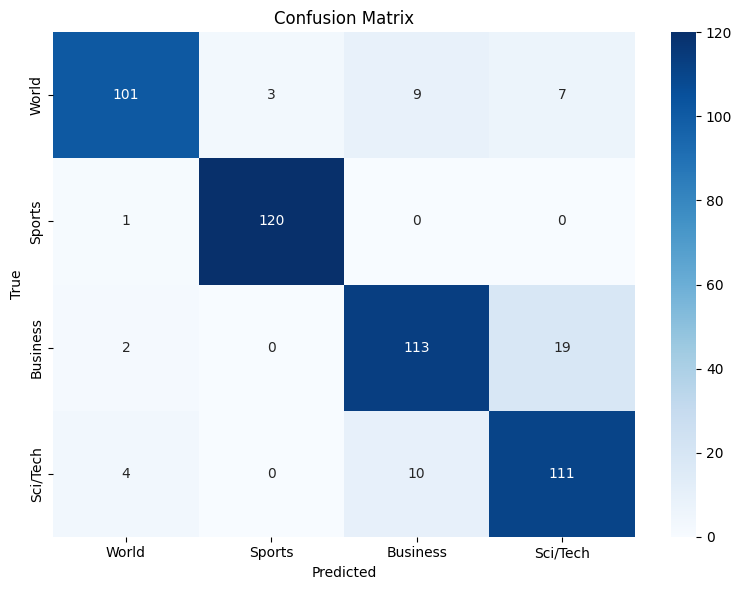


Model saved to ./fine-tuned-distilbert

Text: Scientists discover a new exoplanet
Prediction: Sci/Tech (96.18%)

Text: Stock markets hit record highs
Prediction: Business (95.02%)

Text: The team won the championship final
Prediction: Sports (96.71%)


In [5]:
# =============================================================================
# RUN
# =============================================================================
main()